In [2]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from pennylane.optimize import NesterovMomentumOptimizer

آماده سازی دیتا

In [49]:
#make a 7qubit device
dev = qml.device("default.qubit", wires=7)

In [28]:
#import data
df = pd.read_csv('Iris.csv')
c_data = np.array(df.drop('Species', 1))

#rescale data in order [0,pi/2]
rescale_max = np.pi/2
rescale_ratio = c_data.max()/rescale_max
rescale = lambda x: x/rescale_ratio

rescaled_data = [[rescale(j).numpy() for j in i] for i in c_data]

/tmp/ipykernel_4946/654194577.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  c_data = np.array(df.drop('Species', 1))


In [42]:
#one hat lable set
labels = []
for i in df.get("Species"):
    if i == "Iris-setosa":
        labels.append([1,0,0])
    elif i == "Iris-virginica":
        labels.append([0,0,1])
    else:
        labels.append([0,1,0])

In [43]:
#the unitary matrix thats use for state-preparation
unitary = lambda x: np.array([
    [np.cos(np.pi/4 - x), -np.sin(np.pi/4 - x)],
    [np.sin(np.pi/4 - x), np.cos(np.pi/4 - x)]
                              ])

In [67]:
#the set of all unitary matrixs for each classic data
preparams = [[unitary(j) for j in i] for i in np.array(rescaled_data)]

In [68]:
#split data for train and test
num_data = len(labels)
num_train = int(0.75 * num_data)
X_train = np.array(preparams[:num_train])
Y_train = np.array(labels[:num_train])
X_test = np.array(preparams[num_train:])
Y_test = np.array(labels[num_train:])

ساخت مدار

In [46]:
#the state preparation template
def state_preparator(ums):
    qml.Hadamard(wires=[0])
    qml.QubitUnitary(ums[0], wires=0)
    qml.Hadamard(wires=[1])
    qml.QubitUnitary(ums[1], wires=1)
    qml.Hadamard(wires=[2])
    qml.QubitUnitary(ums[2], wires=2)
    qml.Hadamard(wires=[3])
    qml.QubitUnitary(ums[3], wires=3)

In [47]:
#layes template
def layer(p):
    
    qml.Rot(p[0, 0], p[0, 1], p[0, 2], wires=0)
    qml.Rot(p[1, 0], p[1, 1], p[1, 2], wires=1)
    qml.Rot(p[2, 0], p[2, 1], p[2, 2], wires=2)
    qml.Rot(p[3, 0], p[3, 1], p[3, 2], wires=3)

    qml.Rot(p[4, 0], p[4, 1], p[4, 2], wires=0)
    qml.Rot(p[5, 0], p[5, 1], p[5, 2], wires=1)
    qml.Rot(p[6, 0], p[6, 1], p[6, 2], wires=2)
    qml.Rot(p[7, 0], p[7, 1], p[7, 2], wires=3)
    
    qml.CNOT([3,0])
    qml.CNOT([0,1])
    qml.CNOT([1,2])
    qml.CNOT([2,3])
    qml.CNOT([1,4])
    qml.CNOT([2,5])
    qml.CNOT([3,6])

    qml.Rot(p[8, 0], p[8, 1], p[8, 2], wires=4)
    qml.Rot(p[9, 0], p[9, 1], p[9, 2], wires=5)
    qml.Rot(p[10, 0], p[10, 1], p[10, 2], wires=6)

In [50]:
#configure circuit in a qnode using dev
@qml.qnode(dev)
def Circuit(weights, preparam):

    state_preparator(preparam)

    for w in weights:
        layer(w)

    # return qml.probs(wires=[4, 5, 6])
    return qml.expval(qml.PauliZ(4)), qml.expval(qml.PauliZ(5)), qml.expval(qml.PauliZ(6))

تابع ضرر و تابع هزینه

In [51]:
def softmax(x):
    softmaxed = []
    for i in x:
        a = i/x.sum()
        softmaxed.append(np.array(a))
    return softmaxed

In [1]:
def prediction(weights, preparams):
    #rescaling prediction
    a = Circuit(weights, preparams)
    b = a/2 + 1
    return softmax(b)

In [53]:
def cross_entropy(label, predict):
    loss = 0
    for i in range(3):
        loss += label[i]*np.log(predict[i])
    return -loss

In [54]:
def accuracy(label, weights, preparams):
    acc = 0
    if abs(cross_entropy(label, prediction(weights, preparams))) < 1e-2:
        acc += 1
    return acc

In [15]:
# def cost(weights, preparamses, label):
#     return cross_entropy(label, prediction(weights, preparamses))

In [55]:
def cost(weights, preparamses, label):
    batch_cost = 0
    for l , prep in zip(label, preparams):
        batch_cost += cross_entropy(l, prediction(weights, prep))
    return batch_cost/len(label)

هایپر پارامتر ها و بهینه ساز

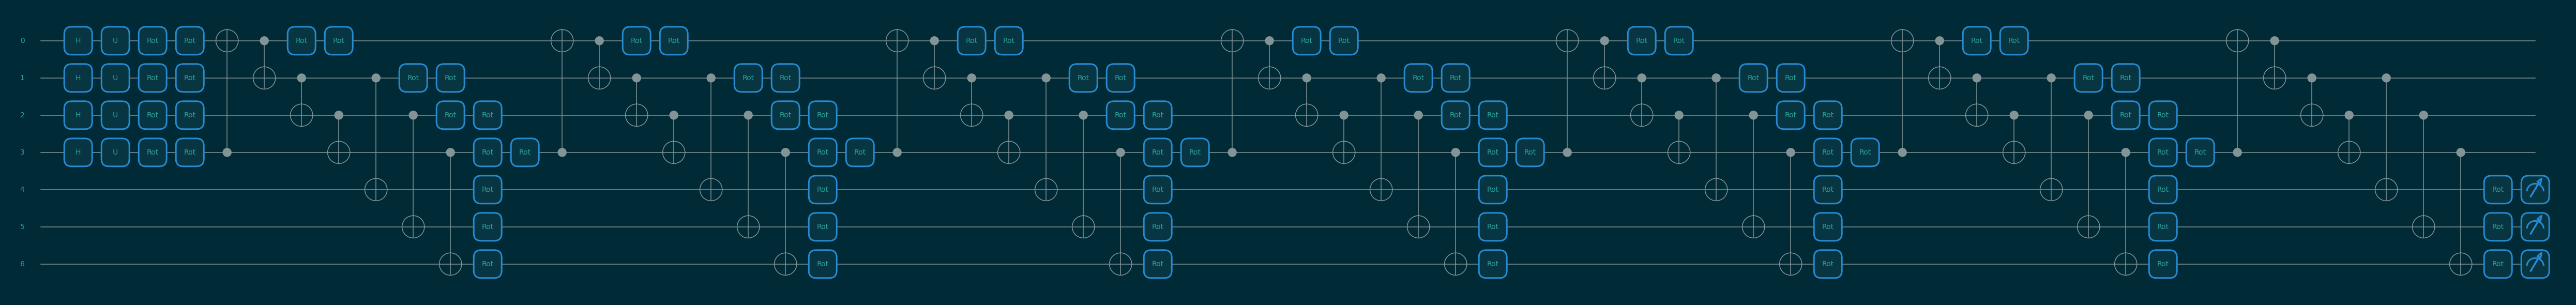

In [100]:
#needs weights_inits hyperparameter
qml.drawer.use_style(style="solarized_dark")
fig, ax = qml.draw_mpl(Circuit)(weights_init, preparams[0])

In [97]:
np.random.seed(0)
batch_size = 5
iteration = 4
weights_init = 0.01 * np.random.randn(7, 11, 3, requires_grad=True)

In [ ]:
opt = NesterovMomentumOptimizer(stepsize=0.01, momentum=0.9)

weights = weights_init

for it in range(iteration):

    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, _, _ = opt.step(cost, weights, X_train_batch, Y_train_batch)

    # predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    # predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # acc_train = accuracy(Y_train, predictions_train)
    # acc_val = accuracy(Y_val, predictions_val)
weights